In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from collections import defaultdict

from lib import Consensus
from lib import Simulation

from lib import ACTIVE_CIRCUITS_PER_SECOND
from lib import ACTIVE_CIRCUITS_PER_SECOND_STD

In [2]:
table = defaultdict(list)

N = (ACTIVE_CIRCUITS_PER_SECOND/100)//64*64
for i in range(10):
    for scale in [0.01] + list(np.arange(0.1, 1.1, 0.1)):
        c = Consensus.generate('../../tor-neverenough/experiments/active-links-0.3.5.18/relayinfo_staging_2021-11-01--2021-11-30.json', network_scale=scale)
        for k in [1, 2, 4, 8, 16, 32, 64]:
            n = int((ACTIVE_CIRCUITS_PER_SECOND*scale)//64*64)
            print('.', end='')
            s = Simulation.from_consensus(c, N=n, k=k, reuse_guards=True).simulate()
            t = s.stat.create_table()
            shared = float(t['Shared Links Percent'])

            table['i'].append(i)
            table['scale'].append(scale)
            table['N'].append(n)
            table['k'].append(k)
            table['shared'].append(shared)

table = pd.DataFrame(table)
table

..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

i  scale      N   k     shared
0    0   0.01    960   1  53.821138
1    0   0.01    960   2  53.697749
2    0   0.01    960   4  53.174603
3    0   0.01    960   8  58.360656
4    0   0.01    960  16  58.096828
..  ..    ...    ...  ..        ...
765  9   1.00  96832   4   3.959553
766  9   1.00  96832   8   4.092782
767  9   1.00  96832  16   4.255273
768  9   1.00  96832  32   4.321445
769  9   1.00  96832  64   4.822625

[770 rows x 5 columns]

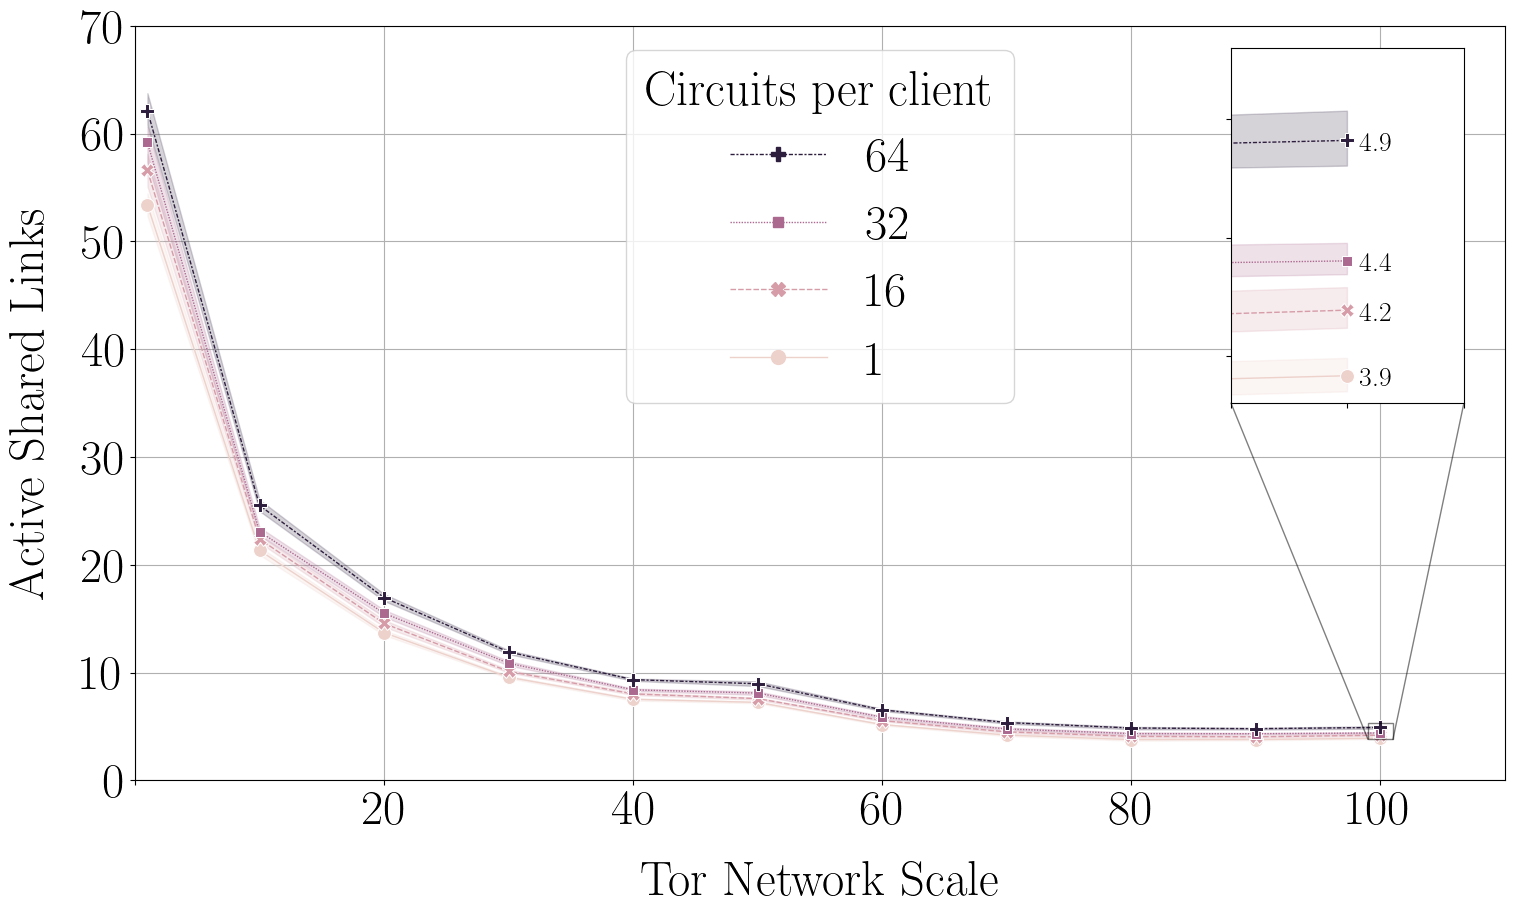

In [3]:
def annotate_value(xy, label=None, offset=(1, 1), ax=None):
    ax.annotate('%.1f %%' % xy[1], xy=xy, xytext=(xy[0] + offset[0], xy[1] + offset[1]), fontsize=20)

def format_percent(x, pos=None, digits=0, xmax=100):
    x = x / xmax * 100
    format_string = '%%.%df %%%%' % digits
    return format_string % x

from functools import partial
 
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

plt.rc('font', family='cmr10')
plt.rc('font', size=35)
plt.rc('axes', axisbelow=True)
plt.rc('axes.formatter', use_mathtext=True)
plt.rc('lines', linewidth=1.0, markersize=10.0)

plt.figure(figsize=(16, 10))
plt.xlim(0, 1.1)
plt.ylim(0, 70)

subtable = table[table['k'].isin([64,32,16,1])]

sns.lineplot(
    data=subtable, 
    x='scale', y='shared', 
    hue=subtable['k'], 
    style=subtable['k'],
    legend='full', 
    marker='o', 
    markers=True, 
    errorbar=('ci', 99), 
    ax=plt.gca()
)
plt.xlabel('Tor Network Scale', labelpad=20)
plt.ylabel('Active Shared Links', labelpad=20)
plt.gca().xaxis.set_major_formatter(partial(format_percent, xmax=1.0))
plt.gca().yaxis.set_major_formatter(partial(format_percent, xmax=100))
plt.grid(visible=True)

ax = plt.gca()
axins = ax.inset_axes([0.8, 0.5, 0.17, 0.47])
sns.lineplot(
    data=subtable, 
    x='scale', y='shared',     
    hue=subtable['k'], 
    style=subtable['k'],
    legend=None, 
    marker='o', 
    markers=True, 
    errorbar=('ci', 99),
    ax=axins
)
axins.set_xlabel(None)
axins.set_ylabel(None)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.grid(False)

axins.set_xlim(0.99, 1.01)
axins.set_ylim(3.8, 5.3)

ax.indicate_inset_zoom(axins, edgecolor="black")

annotate_value((1.0, subtable[(subtable['scale'] == 1.00) & (subtable['k'] == 64)].mean()['shared']), label='Test', offset=(0.001, -0.04), ax=axins)
annotate_value((1.0, subtable[(subtable['scale'] == 1.00) & (subtable['k'] == 32)].mean()['shared']), label='Test', offset=(0.001, -0.04), ax=axins)
annotate_value((1.0, subtable[(subtable['scale'] == 1.00) & (subtable['k'] == 16)].mean()['shared']), label='Test', offset=(0.001, -0.04), ax=axins)
annotate_value((1.0, subtable[(subtable['scale'] == 1.00) & (subtable['k'] ==  1)].mean()['shared']), label='Test', offset=(0.001, -0.04), ax=axins)

handles, labels = plt.gca().get_legend_handles_labels()
legend = list(zip(handles, labels))
legend = [legend[3], legend[2], legend[1], legend[0]]
handles, labels = zip(*legend)
plt.legend(handles, labels, title='Circuits per client')

plt.gca().get_xticklabels()[0].set_color('white')
plt.tight_layout()
plt.savefig('paper-guard-reuse.pdf')
plt.show()